# Connected Component Decomposition for Single Cell RNA Seq Data

This Jupyter notebook contains code to reproduce the results in "Network Analysis of Single-Cell RNA seq Reveals Metabolic Heterogeneity of Human White Adipocytes."   The algorithm is described in that paper and its supplemental material.

This decomposition has two principal inputs: a matrix $X$ of single-cell expression data, and a protein interaction network.

<img src="overview-fig.png" width=400/>

Given these inputs, the goal is to find subnetworks of the PPI network along with associated cell-specific activity levels for each network.

This problem is expressed as 

$$ \min_{C,G} \Vert X - CG\Vert^2_F $$

such that

$$ C \in \mathbb{R}^{m\times r}, G \in \{0,1\}^{r\times n} $$

and each row of G encodes a connected component, i.e.,

$$ M_{g_i} \mbox{ is connected } \forall i \in [r] $$

The algorithm used attempts to solve this problem heuristically.

In [1]:
import numpy as np
import scipy as sp
import scipy.sparse as sparse
from scipy import stats
import numpy.ma as ma
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import rc
import os
import logging
import sys
sys.path.insert(0, "src")
import CG

<module 'CG' from 'src/CG.py'>

## Load Data

In [2]:
with open('data/protein_names.txt') as fp:
    protein_names = [f.strip() for f in fp]
with open('data/cell_names.txt') as fp:
    cell_names = [f.strip() for f in fp]
M = nx.read_graphml('data/PPI_network_GCC.gml')
M = M.subgraph(protein_names)
UMI_matrix = sparse.load_npz('data/UMI_matrix.npz')
UMI_matrix = np.array(UMI_matrix.todense())

## Initialize and Normalize Counts

In [3]:
# logging.WARNING -> no logging
# logging.INFO -> standard logging
# logging.DEBUG -> full logging
D = CG.CG_decomposition(M, UMI_matrix, protein_names, cell_names, 'log+zscore', logging.INFO)

## Set Algorithm Parameters

In [4]:
rank = 4
number_of_candidates = 10
subnetwork_size = 30

## Perform Decomposition

In [5]:
C, G, networks, residual_matrix, residual_errors, subnetwork_decrements = D.decom(rank, 
                                                                         number_of_candidates, 
                                                                         subnetwork_size)

INFO:root:number_of_candidates: 10
INFO:root:max_subnetwork_size: 30
INFO:root:network 0 is ['FTL', 'FTH1', 'B2M', 'MT2A', 'RPLP1', 'RPS4X', 'RPS18', 'RPL6', 'RPL26', 'EEF1A1', 'MTRNR2L1', 'FN1', 'RPL41', 'RPS15A', 'RPL10', 'RPS19', 'RPS14', 'RPL17', 'COL1A2', 'RPS24', 'COL1A1', 'MYL6', 'RPS27', 'RPL7', 'RPS6', 'RPL11', 'RPS23', 'RPLP0', 'RPL35A', 'SPARC']
INFO:root:network 1 is ['ZNF665', 'ZNF587', 'ZNF714', 'ZNF490', 'ZNF264', 'CBX5', 'VHL', 'LPP', 'TFDP2', 'MCTS1', 'ZNF529', 'ZNF793', 'ZNF557', 'ZFP14', 'RBBP4', 'IRGQ', 'TPM3', 'XPNPEP3', 'TRPM7', 'GATAD1', 'SGPL1', 'ANAPC16', 'ZNF621', 'SCAI', 'ZNF738', 'SPATS2L', 'AAK1', 'PGAM5', 'XIAP', 'EXPH5']
INFO:root:network 2 is ['COL3A1', 'ACTG1', 'LGALS1', 'ANXA2', 'ACTB', 'TMSB4X', 'RPL35', 'RPS3A', 'RPS27A', 'RPS12', 'RPL32', 'RPL39', 'RPL13A', 'RPL15', 'RPS11', 'RPS8', 'RPS9', 'RPL10A', 'RPL3', 'RPL21', 'RPL37A', 'RPL28', 'RPS5', 'RPL19', 'TPT1', 'GNB2L1', 'RPL34', 'RPS2', 'RPLP2', 'RPS15']
INFO:root:network 3 is ['DCN', 'COL6A1', 'UBC

## Compute the optimal C and the final error given the chosen G 

In [7]:
C_BackProjection = UMI_matrix @ np.linalg.pinv(G)
BackProjection_error = np.linalg.norm(UMI_matrix - C_BackProjection @ G)
print('Final error is {}, capturing {:.2%} of variation in X'.format(
    BackProjection_error, BackProjection_error/np.linalg.norm(UMI_matrix)))

Final error is 6707.425601525546, capturing 85.41% of variation in X


## Plot the chosen subnetworks

In [8]:
%matplotlib inline

rc('font', size=15)
rc('axes', labelsize='X-large')
rc('axes', titlesize='large')

output_directory = 'plots'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

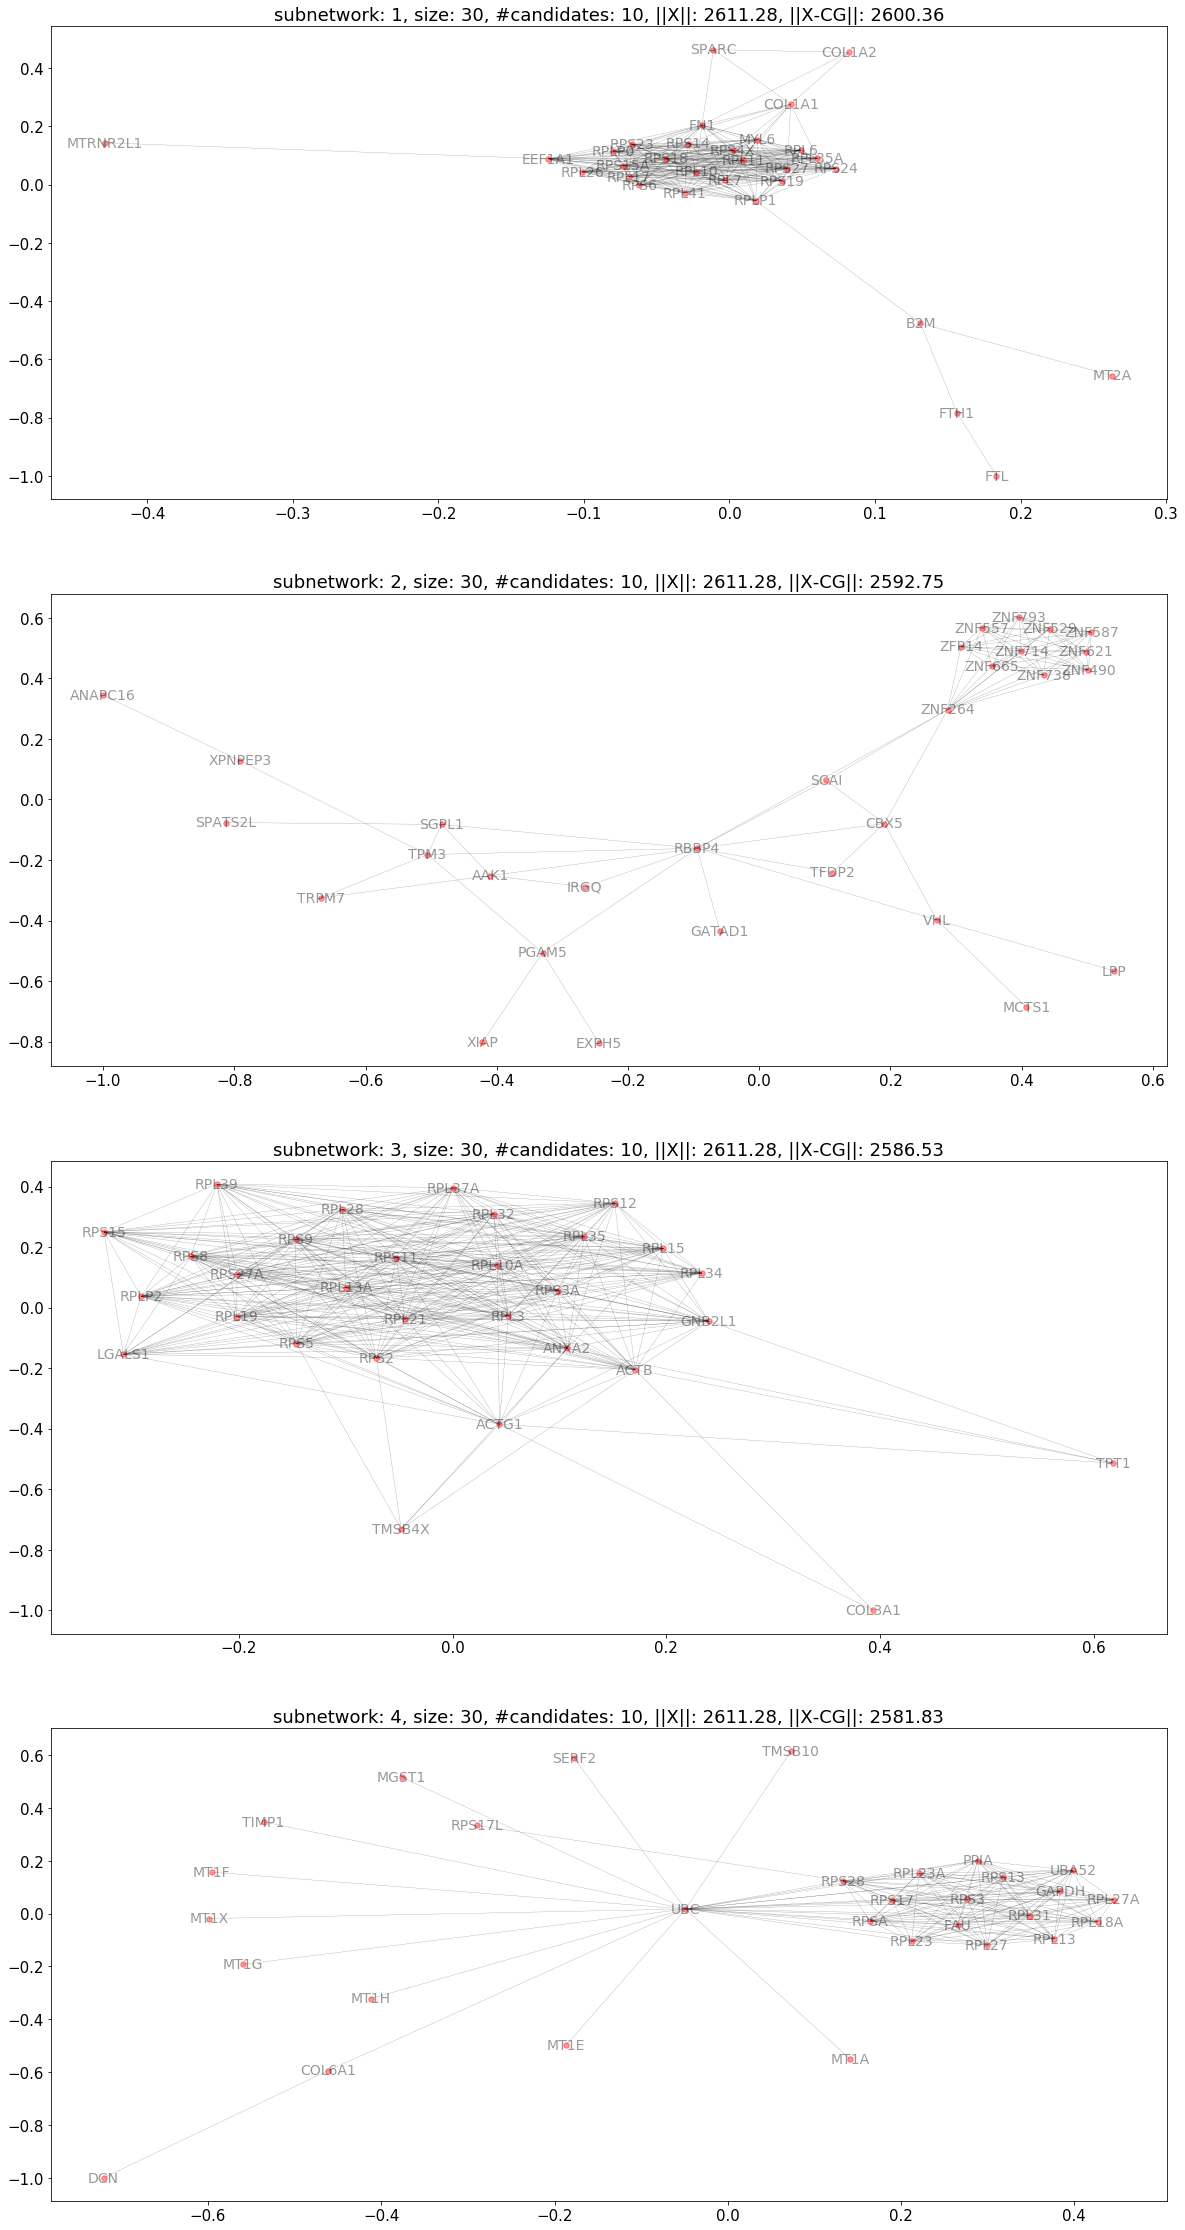

In [11]:
np.random.seed(0)
fig = plt.figure(figsize=(20, 40))
for r in range(rank):
    ax = fig.add_subplot(rank, 1, r+1)
    ax.set_title(
        'subnetwork: {}, size: {}, #candidates: {}, ||X||: {:.2f}, ||X-CG||: {:.2f}'.format(
            r+1,                                                                                       
            subnetwork_size, 
            number_of_candidates, 
            residual_errors[0],
            residual_errors[r+1]))
    detected_subgraph = M.subgraph(networks[r])
    nx.draw_networkx(detected_subgraph, 
                     width = 0.3,
                     with_labels=True, 
                     node_size= 30, 
                     alpha = 0.4, 
                     font_size  = 14)
plt.savefig('{:s}/rank{:d}_{:d}_{:d}.pdf'.format(output_directory, 
                                    rank, 
                                    subnetwork_size, 
                                    number_of_candidates),  format='pdf')